## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration with Chessboard Images

### Finding chessboard corners

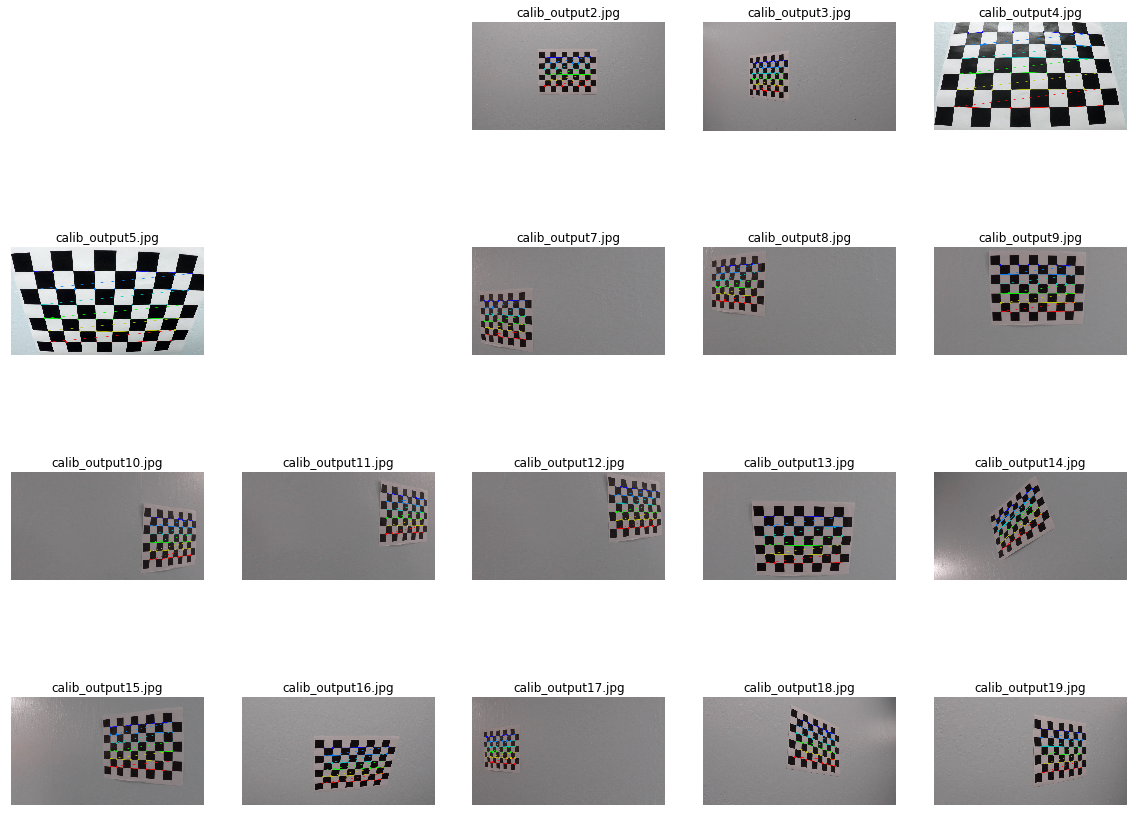

In [79]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Setup the grid layout for output
plt.figure(figsize = (20,20))
grid = gridspec.GridSpec(5,5)

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret is True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        calib_output_name = 'calib_output'+str(i)+'.jpg'
        grid_plt = plt.subplot(grid[i])
        plt.axis('on')
        grid_plt.set_xticklabels([])
        grid_plt.set_yticklabels([])
        plt.imshow(img)
        plt.title(calib_output_name)
        plt.axis('off')
plt.show()
# cv2.destroyAllWindows()

###  Un-distort one of the calibration images provided as a demonstration that the calibration is correct

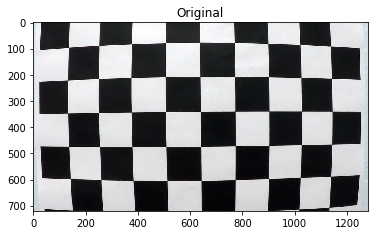

In [80]:
# Helper func to display images inline with title
def disp_gray_img(title, img):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()
    
def disp_img(title, img):
    plt.imshow(img)
    plt.title(title)
    plt.show()

img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
disp_img('Original', img)

### Do camera calibration given object points and image points

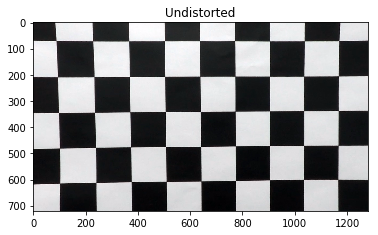

In [81]:
# Perfrm camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the calibration matrix for later use
save_pickle = {}
save_pickle["mtx"] = mtx
save_pickle["dist"] = dist
pickle.dump(save_pickle, open("calib_mat_save.p", "wb"))

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../calibration_output/undist_output.jpg',dst)
disp_img('Undistorted', dst)

### Undistorting a test image

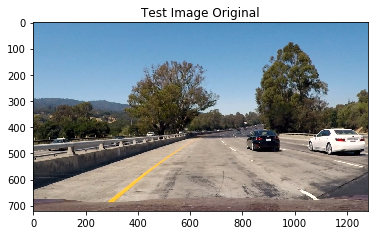

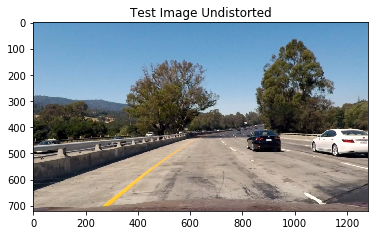

True

In [82]:
lane_img = cv2.imread('../test_images/test1.jpg')
lane_img = cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB)

lane_img_undist = cv2.undistort(lane_img, mtx, dist, None, mtx)

disp_img('Test Image Original', lane_img)
disp_img('Test Image Undistorted', lane_img_undist)
cv2.imwrite('../calibration_output/undist_output.jpg',dst)

### Creating a thresholded binary image using sobel, directional, magnitude thresholds

In [83]:
img = cv2.imread('../test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

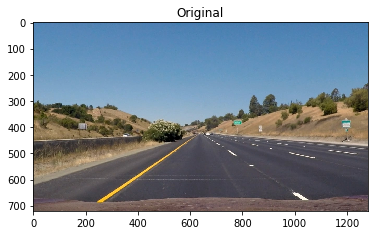

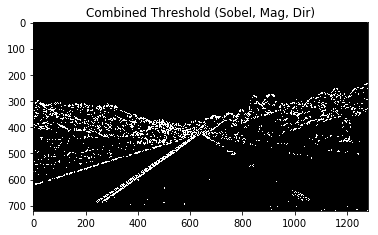

In [84]:

# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # disp_img('gray', gray)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # Calculate the derivative in the xx direction (the 1, 0 at the end denotes xx direction)
    if orient == 'x':
        sobel_img = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        # disp_img('sobelx', sobel_img)
    else:
        # 2.5 Calculate the derivative in the yy direction (the 0, 1 at the end denotes y direction)
        sobel_img = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        # disp_img('sobely', sobel_img)

    # 3) Take the absolute value of the derivative or gradient
    # Calculate the absolute value of the xx derivative
    abs_sobel = np.absolute(sobel_img)
    # disp_img('abs_sobel', abs_sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 4. Convert the absolute value image to 8-bit
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # disp_img('scaled_sobel', scaled_sobel)

    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    # Create a binary threshold to select pixels based on gradient strength
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # disp_img('sxbinary', sxbinary)

    # 6) Return this mask as your binary_output image
    return sxbinary

# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # disp_img('gray', gray)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # disp_img('sobelx', sobel_x)

    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # disp_img('sobely', sobel_y)

    # 3) Calculate the magnitude
    mag = np.sqrt(sobel_x**2 + sobel_y**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag / np.max(mag))
    # disp_img('scaled_sobel', scaled_sobel)

    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # disp_img('sxbinary', sxbinary)

    # 6) Return this mask as your binary_output image
    return sxbinary

# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # disp_img('gray', gray)

    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # disp_img('sobelx', sobel_x)

    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # disp_img('sobely', sobel_y)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    # disp_img('abs_sobelx', abs_sobelx)

    abs_sobely = np.absolute(sobel_y)
    # disp_img('abs_sobely', abs_sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # disp_img('sxbinary', sxbinary)

    # 6) Return this mask as your binary_output image
    return sxbinary

kernel_size = 15

# Run the combined function
def combined_threshold(image):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=kernel_size, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=kernel_size, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=kernel_size, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=kernel_size, thresh=(0.7, 1.3))
    combined_img = np.zeros_like(dir_binary)
    combined_img[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined_img

combined_gradient = combined_threshold(img)
disp_img('Original', img)
disp_gray_img('Combined Threshold (Sobel, Mag, Dir)', combined_gradient)

### Creating a thresholded binary image using color thresholds and gradient thresholds

In [85]:
def color_threshold(img, s_thresh=(100, 255), sx_thresh=(20, 100), v_thresh=(50, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate l and s channels
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    # Convert to HSV color space and separate v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:, :, 2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    disp_gray_img('Sobel_L', scaled_sobel)
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    disp_gray_img('X Gradient Thresholded Sobel L', sxbinary)

    # Threshold V channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    disp_gray_img('V Threshold', v_binary)

    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    disp_gray_img('S Channel', s_binary)
    
    # Combine V & S first
    vs_binary = np.zeros_like(s_channel)
    vs_binary[(v_binary == 1) & (s_binary == 1)] = 1
    disp_gray_img('VS Binary', vs_binary)
    
    # Stack Sobel L X-Gradient on V&S Binary
#     color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, vs_binary)) * 255
#     disp_gray_img('Color Stacked', color_binary)
    
    combined_color = np.zeros_like(sxbinary)
    combined_color[(vs_binary == 1) | (sxbinary == 1)] = 1
    return combined_color

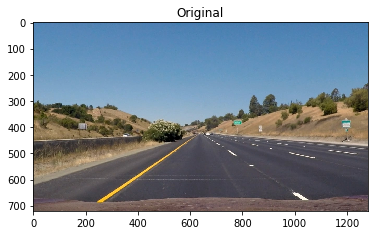

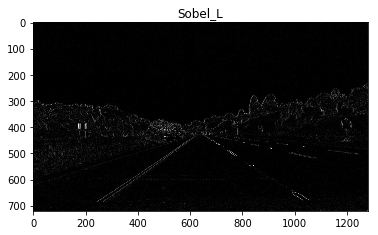

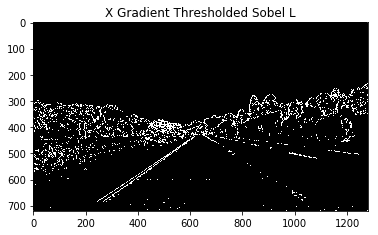

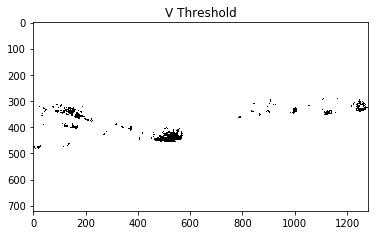

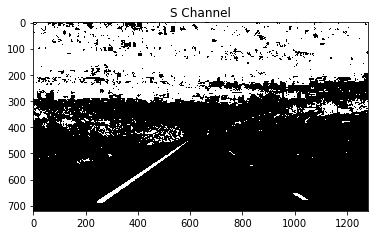

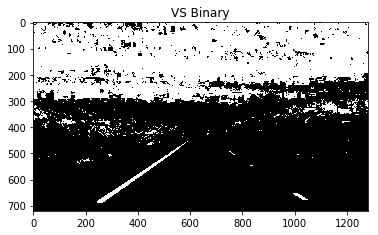

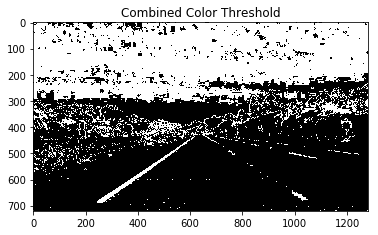

In [92]:
disp_img('Original', img)
combined_color = color_threshold(img)
disp_gray_img('Combined Color Threshold', combined_color)

### Now combining gradient and color thresholds

In [119]:
color_grad_img = np.zeros_like(img[:, :, 0])
gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255))
grady = abs_sobel_thresh(img, orient='y', thresh=(25,255))
# gray_combined_color = cv2.cvtColor(combined_color, cv2.COLOR_RGB2GRAY)
# gray_combined_grad = cv2.cvtColor(combined_gradient, cv2.COLOR_RGB2GRAY)
# print(gradx.shape)
# print(grady.shape)
# print(combined_gradient.shape)
# print(combined_color.shape)
# print(combined_gradient)
# print(combined_color)
# color_grad_img = np.zeros_like(combined_color)
bitwise_and(combined_gradient, gray_combined_color, res, color_grad_img)
# color_grad_img[(combined_gradient == 1) | (combined_color == 1)]
disp_gray_img('Color Gradient Image', color_grad_img)

error: OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::SizePolicy::NONE>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::SizePolicy::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1
